<a href="https://colab.research.google.com/github/hiebschi/MoSE_scripts/blob/main/loop_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Implementing a Segmentation Model

## 1. Preparations
### 1.1 Install required packages

In [1]:
import json
import os
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np

### 1.2 Install segmentation model

In [2]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0c6ce75fc5a0479ba52a124747e9602c39efb597700bc95dedcdde612c9b3917
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e5c0d45be4d2d605d4960576ef31fcb459106afebc06074130a28ab0a784acab
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [3]:
import segmentation_models_pytorch as smp

### 1.3 Device agnostic code

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Upload data to colab

In [5]:
# manual upload (for small files)
# from google.colab import files
# uploaded = files.upload()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Data directories on GOOGLE DRIVE  # -------------------->> ADJUSTABLE
# npy preprocessed patches
preprocessed_patches_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/preprocessed_patches'
# npy patches and masks > NOT PREPROCESSED
patches_masks_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/patches'
# JSON class codes
codes_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/classes'
# Shapefile class labels
labels_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/shapefiles'


In [10]:
# Class labels
# specific Shapefile path
shp_path = os.path.join(labels_dir, "GSK_24_WGS84_adjusted.shp") # -------------------->> ADJUSTABLE

labels = gpd.read_file(shp_path) # read shapefile
labels_filtered = labels[labels["Elementtyp"].notnull()] # remove NULL
print(labels_filtered["Elementtyp"].unique()) # print all label classes

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


In [11]:
# Class codes
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9}


9

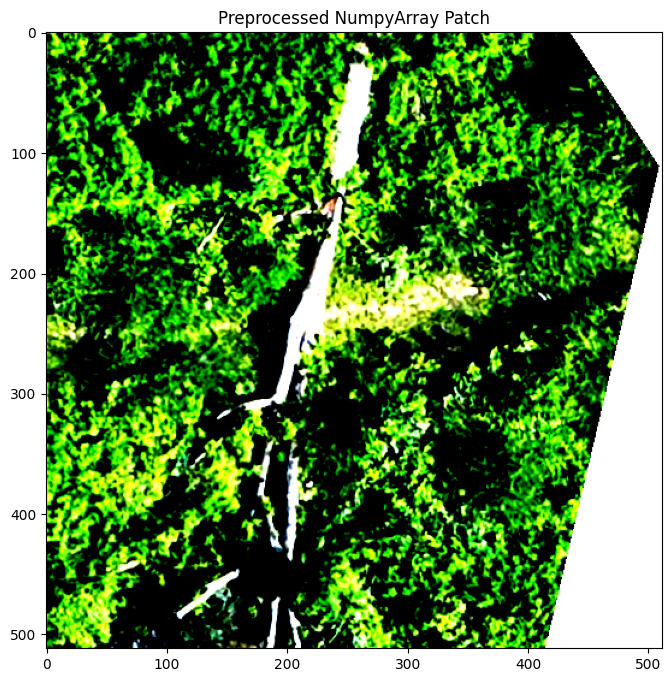

In [12]:
# Test preprocessed patch

#####################
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 197 # -------------------->> ADJUSTABLE
#####################

test_pre_patch_path = preprocessed_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (NO DICTIONARY ANYMORE)
test_pre_patch = np.load(test_pre_patch_path)

# plot the preprocessed image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_pre_patch.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("Preprocessed NumpyArray Patch")
plt.show()

In [ ]:
# create list with preprocessed patches
pre_patches_list = [f for f in os.listdir(preprocessed_patches_dir) if f.endswith('.npy')]  # list of all patches (not the masks)
pre_patches_list.sort() # sort list alphabetically
# patches_list

## 2. Choose segmentation model

In [13]:
model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 289MB/s]


## 3. Training and  testing loop

### 3.1 Choose optimizer and loss function

In [14]:
loss = smp.losses.DiceLoss(mode="multiclass")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)